# $k$-Anonymity

## 1) De-identification

*De-identification* is the process of removing *identifying information* from a dataset. The term *de-identification* is sometimes used synonymously with the terms *anonymization* and *pseudonymization*.

Identifying information has no formal definition. It is usually understood to be information which would be used to identify us uniquely in the course of daily life - name, address, phone number, e-mail address, etc. As we will see later, it's *impossible* to formalize the concept of identifying information, because *all* information is identifying. The term *personally identifiable information (PII)* is often used synonymously with identifying information.

How do we de-identify information? Easy - we just remove the columns that contain identifying information!

Through the exercise, we will work with the “Adult” dataset ("incomes.csv"), which contains information extracted from the 1994 US census database, and serves as a de facto standard for the evaluation of anonymization algorithms. You can find a detailed description of the dataset in the UCI machine learning repository: http://www.cs.toronto.edu/~delve/data/adult/desc.html.

Let’s start loading and exploring the dataset:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
adult = pd.read_csv("incomes.csv")
adult.head()

,Name,DOB,SSN,Zip,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,Karrie Trusslove,9/7/1967,732-14-6110,64152,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,Brandise Tripony,6/7/1988,150-19-2766,61523,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,Brenn McNeely,8/6/1991,725-59-9860,95668,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,Dorry Poter,4/6/2009,659-57-4974,25503,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,Dick Honnan,9/16/1951,220-93-3811,75387,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Now we create a de-identified version of the dataset:

In [3]:
adult_data = adult.copy().drop(columns=['Name', 'SSN'])
adult_data.head(1)

,DOB,Zip,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,9/7/1967,64152,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K


**<h4>Question:</h4>** Do you think the applied de-anonymization is enough to protect the data privacy? Why?

Solution:

It’s not enough, there are quasi-identifiers, such as ZIP and DOB, which can be used to individuate a person in the dataset.

## Linkage Attacks

Imagine we want to determine the income of a friend from our de-identified data. Names have been removed, but we happen to know some auxiliary information about our friend. Our friend's name is Karrie Trusslove, and we know Karrie's date of birth and zip code.

To perform a simple *linkage attack*, we look at the overlapping columns between the dataset we're trying to attack, and the auxiliary data we know. In this case, both datasets have dates of birth and zip codes. We look for rows in the dataset we're attacking with dates of birth and zip codes that match Karrie's date of birth and zip code. In databases, this is called a *join* of two tables, and we can do it in Pandas using `merge`. If there is only one such row, we've found Karrie's row in the dataset we're attacking.

In [4]:
#Our auxiliary data 
adult_pii = adult[['Name', 'SSN', 'DOB', 'Zip']]
karries_row = adult_pii[adult_pii['Name'] == 'Karrie Trusslove']


#Linkage attack
pd.merge(karries_row, adult_data, left_on=['DOB', 'Zip'], right_on=['DOB', 'Zip'])

,Name,SSN,DOB,Zip,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,Karrie Trusslove,732-14-6110,9/7/1967,64152,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K


**<h4>Question:</h4>** Was the attack successful? What do we infer about Karrie?



Solution: Indeed, there is only one row that matches. We have used auxiliary data to re-identify an individual in a de-identified dataset, and we're able to infer that Karrie's income is less than $50k.

### How Hard is it to Re-Identify Karrie?

This scenario is made up, but linkage attacks are surprisingly easy to perform in practice. How easy? It turns out that in many cases, just one data point is sufficient to pinpoint a row!

In [5]:
pd.merge(karries_row, adult_data, left_on=['Zip'], right_on=['Zip'])

,Name,SSN,DOB_x,Zip,DOB_y,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,Karrie Trusslove,732-14-6110,9/7/1967,64152,9/7/1967,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K


So ZIP code is sufficient **by itself** to allow us to re-identify Karrie. What about date of birth?

**<h4>Question:</h4>** Launch an attack to re-identify Karrie based on the DOB code.

In [31]:
# solution:
pd.merge(karries_row, adult_data, left_on=['DOB'], right_on=['DOB'])

,Name_x,SSN_x,DOB,Zip_x,Name_y,SSN_y,Zip_y,Age,Workclass,fnlwgt,...,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,Karrie Trusslove,732-14-6110,9/7/1967,64152,Karrie Trusslove,732-14-6110,64152,39,State-gov,77516,...,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,Karrie Trusslove,732-14-6110,9/7/1967,64152,Kyle Lynas,748-95-9708,67306,64,Private,171373,...,Widowed,Farming-fishing,Unmarried,White,Female,0,0,40,United-States,<=50K
2,Karrie Trusslove,732-14-6110,9/7/1967,64152,Arlyn Skivington,579-69-0687,62254,46,Self-emp-not-inc,119944,...,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,>50K


**<h4>Question:</h4>** Was the attack successful? What do we infer about Karrie?


Solution: 

This time, there are three rows returned - and we don't know which one is the real Karrie. But we've still learned a lot!

- We know that there's a 2/3 chance that Karrie's income is less than $50k
- We can look at the differences between the rows to determine what additional auxiliary information would *help* us to distinguish them (e.g. sex, occupation, marital status)

### Is Karrie Special?

How hard is it to re-identify others in the dataset? Is Karrie especially easy or especially difficult to re-identify? A good way to gauge the effectiveness of this type of attack is to look at how "selective" certain pieces of data are - how good they are at narrowing down the set of potential rows which may belong to the target individual. For example, is it common for birthdates to occur more than once?

We'd like to get an idea of how many dates of birth are likely to be useful in performing an attack, which we can do by looking at how common "unique" dates of birth are in the dataset. The histogram below shows that *the vast majority* of dates of birth occur 1, 2, or 3 times in the dataset, and *no date of birth* occurs more than 8 times. This means that date of birth is fairly *selective* - it's effective in narrowing down the possible records for an individual.

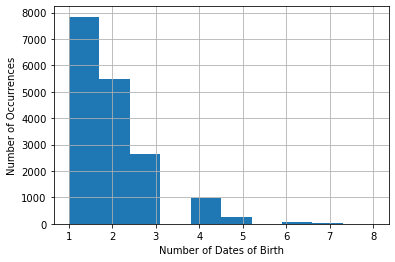

In [7]:
adult_pii['DOB'].value_counts() .hist()
plt.xlabel('Number of Dates of Birth')
plt.ylabel('Number of Occurrences');

We can do the same thing with ZIP codes, and the results are even worse - ZIP code happens to be *very* selective in this dataset. Nearly all the ZIP codes occur only once.

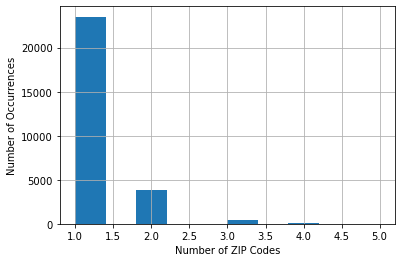

In [8]:
adult_pii['Zip'].value_counts().hist()
plt.xlabel('Number of ZIP Codes')
plt.ylabel('Number of Occurrences');

### How Many People can we Re-Identify?

In this dataset, how many people can we re-identify uniquely? We can use our auxiliary information to find out! First, let's see what happens with just dates of birth. We want to know how many *possible identities* are returned for each data record in the dataset. The following histogram shows the number of records with each number of possible identities. The results show that we can uniquely identify almost 7,000 of the data records (out of about 32,000), and an additional 10,000 data records are narrowed down to two possible identities.

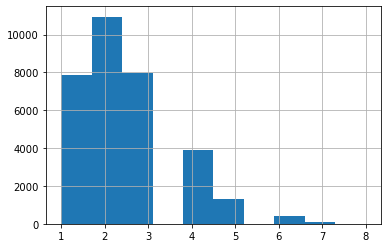

In [9]:
attack = pd.merge(adult_pii, adult_data, left_on=['DOB'], right_on=['DOB'])
attack['Name'].value_counts().hist();

So it's not possible to re-identify a majority of individuals using *just* date of birth. What if we collect more information, to narrow things down further? If we use both date of birth and ZIP, we're able to do much better. In fact, we're able to uniquely re-identify basically the whole dataset.

**<h4>Question:</h4>** Use both date of birth and ZIP to see how re-identifiable are the subjects in the dataset. What is the result?

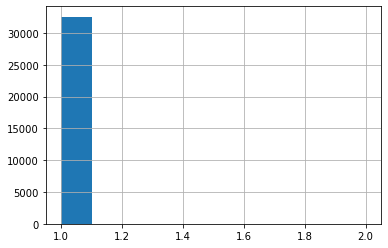

In [10]:
# solution:
attack = pd.merge(adult_pii, adult_data, left_on=['DOB', 'Zip'], right_on=['DOB', 'Zip'])
attack['Name'].value_counts().hist();
#If we use both date of birth and ZIP, we’re able to uniquely re-identify basically the whole dataset.

When we use both pieces of information, we can re-identify **essentially everyone**. This is a surprising result, since we generally assume that many people share the same birthday, and many people live in the same ZIP code. It turns out that the *combination* of these factors is **extremely** selective. 

Let's just check that we've actually re-identified *everyone*, by printing out the number of possible data records for each identity:

In [11]:
attack['Name'].value_counts().head()

Barnabe Haime       2
Antonin Chittem     2
Karrie Trusslove    1
Renault Hylden      1
Nerty Matashkin     1
Name: Name, dtype: int64

Looks like we missed two people! In other words, in this dataset, only **two people** share a combination of ZIP code and date of birth.

### To sum up identification

- A *linkage attack* involves combining *auxiliary data* with *de-identified data* to *re-identify* individuals.
- In the simplest case, a linkage attack can be performed via a *join* of two tables containing these datasets.
- Simple linking attacks are surprisingly effective:
  - Just a single data point is sufficient to narrow things down to a few records
  - The narrowed-down set of records helps suggest additional auxiliary data which might be helpful
  - Two data points are often good enough to re-identify a huge fraction of the population in a particular dataset
  - Three data points (gender, ZIP code, date of birth) uniquely identify 87% of people in the US
  
  
 Given the limitations of de-identification, mechanisms like **k-anonymity** were proposed to anonymize datasets providing further privacy guarantees.

## 2) Checking for $k$-Anonymity

We'll start with a small dataset, so that we can immediately see by looking at the data whether it satisfies $k$-Anonymity or not. This dataset contains age plus two test scores; it clearly doesn't satisfy $k$-Anonymity for $k > 1$. Any dataset trivially satisfies $k$-Anonymity for $k = 1$, since each row can form its own group of size 1.

In [12]:
raw_data = {     
    'age': [42, 52, 36, 24, 73], 
    'preTestScore': [4, 24, 31, 2, 3],
    'postTestScore': [25, 94, 57, 62, 70]}
df = pd.DataFrame(raw_data, columns = ['age', 'preTestScore', 'postTestScore'])
df

,age,preTestScore,postTestScore
0,42,4,25
1,52,24,94
2,36,31,57
3,24,2,62
4,73,3,70


To implement a function to check whether a dataframe satisfies $k$-Anonymity, we loop over the rows; for each row, we query the dataframe to see how many rows match its values for the quasi-identifiers. If the number of rows in any group is less than $k$, the dataframe does not satisfy $k$-Anonymity for that value of $k$, and we return False. Note that in this simple definition, we consider *all* columns to contain quasi-identifiers; to limit our check to a subset of all columns, we would need to replace the `df.columns` expression with something else.

In [13]:
def isKAnonymized(df, k):
    for index, row in df.iterrows():
        query = ' & '.join([f'{col} == {row[col]}' for col in df.columns])
        rows = df.query(query)
        if rows.shape[0] < k:
            return False
    return True

_ToDo:_ $2a)$ Now test, if the example satisfies $k$-Anonymity for $k = 2$. Why or why not?

In [14]:
# solution:
isKAnonymized(df, 2)
#is false because
#definition says every tuple in the table shares
#its quasi identifier value with at least k-1 (in this case 1) other values in the table, not the case!

False

_ToDo:_ $2b)$ Now test, if the example satisfies $k$-Anonymity for $k = 1$. Why or why not?

In [15]:
# solution:
isKAnonymized(df, 1)
#is true because
#there is not one tuple in the table that shares its quasi identifiers value another value in the table.

True

## 3) Generalizing Data to Satisfy $k$-Anonymity

The process of modifying a dataset so that it satisfies $k$-Anonymity for a desired $k$ is generally accomplished by *generalizing* the data - modifying values to be less specific, and therefore more likely to match the values of other individuals in the dataset. For example, an age which is accurate to a year may be generalized by rounding to the nearest 10 years, or a ZIP code might have its rightmost digits replaced by zeros. For numeric values, this is easy to implement. We'll use the `apply` method of dataframes, and pass in a dictionary named `depths` which specifies how many digits to replace by zeros for each column. This gives us the flexibility to experiment with different levels of generalization for different columns.

In [16]:
def generalize(df, depths):
    return df.apply(lambda x: x.apply(lambda y: int(int(y/(10**depths[x.name]))*(10**depths[x.name]))))

Now, we can generalize our example dataframe. First, we'll try generalizing each column by one "level" - i.e. rounding to the nearest 10.

In [17]:
depths = {
    'age': 1,
    'preTestScore': 1,
    'postTestScore': 1
}
df2 = generalize(df, depths)
df2

,age,preTestScore,postTestScore
0,40,0,20
1,50,20,90
2,30,30,50
3,20,0,60
4,70,0,70


_ToDo:_ $3a)$ Check, whether the generalized dataframe satisfies $k$-Anonymity for $k = 2$.

In [18]:
# solution:
isKAnonymized(df2, 2)

False

_ToDo:_ $3b)$ Generalize the dataframe by the second level. 

In [19]:
# solution:
depths = {
    'age': 2,
    'preTestScore': 2,
    'postTestScore': 2
}
generalize(df, depths)

,age,preTestScore,postTestScore
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


_ToDo:_ $3c)$ Could you observe any problems or challenges?

In [20]:
# solution
#we ended up removing all of the data. One of key challenges of achieving $k$-Anonymity is often
#removing quite a lot of information from the data to achieve k-Anon for meaningful values of k.

_ToDo:_ $3d)$ Create an example with at least 6 rows which is not anonymized in the beginning. Then try reaching $3$-Anonymity. For reaching $k$ = 3, apply at least a 1-level generalization. You may look at the example provided on the slides of the lecture.

In [21]:
# solution:
raw_data = {     
    'zipcode': [28357, 28356, 28401, 28405, 28359, 28407],
    'age': [26, 29, 42, 48, 25, 40],
    'score': [305, 309, 506, 506, 301, 500]}
df3 = pd.DataFrame(raw_data, columns = ['zipcode', 'age', 'score'])
df3

#first check of k-anon
isKAnonymized(df3, 1) 
#has to be true

#1-level generalization
depths = {
    'zipcode': 1,
    'age': 1,
    'score': 1
}
df4 = generalize(df3, depths)
df4

#second check of k-anon
isKAnonymized(df4, 3) 
#has to be true

True

## 4) Does More Data Improve Generalization?

In some cases dataset is too small for $k$-Anonymity to work well. Because there are only 5 individuals in the dataset of the first example, building groups of 2 or more individuals who share the same properties is difficult. The solution to this problem is more data: in a dataset with more individuals, less generalization will typically be needed to satisfy $k$-Anonymity for a desired $k$.

Let's try the same census data we examined for de-identification. This dataset contains more than 32,000 rows, so it should be easier to achieve $k$-Anonymity.

In [22]:
adult_data = pd.read_csv("incomes.csv")
adult_data.head()

,Name,DOB,SSN,Zip,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,Karrie Trusslove,9/7/1967,732-14-6110,64152,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,Brandise Tripony,6/7/1988,150-19-2766,61523,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,Brenn McNeely,8/6/1991,725-59-9860,95668,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,Dorry Poter,4/6/2009,659-57-4974,25503,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,Dick Honnan,9/16/1951,220-93-3811,75387,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


We'll consider the ZIP code, age, and educational achievement of each individual to be the quasi-identifiers. We'll project just age and educational achievement-columns, and try to achieve $k$-Anonymity for $k=2$. The data is already $k$-Anonymous for $k=1$.

In [23]:
df = adult_data[['Age', 'Education-Num']]
df.columns = ['age', 'edu']

_ToDo:_ $4a)$ Now check whether that extract of dataset satisfies $k$-Anonymity for $k = 2$. If you run the function for $k = 1$ on the data, you will find that it takes a very long time. Why isn't it that the case for $k = 2$?

In [24]:
#solution:
isKAnonymized(df, 2)
# For $k=2$, our algorithm finds a failing row quickly and finishes fast.

False

_ToDo:_ $4b)$ Try generalizing the data to achieve $2$-Anonymity. Is it possible? Remember the long computation times.

In [30]:
#solution
# outliers are a real problem!
depths = {
    'age': 1,
    'edu': 1
}
df2 = generalize(df.head(1000), depths)
isKAnonymized(df2, 2)

True

The generalized result still does not satisfy $k$-Anonymity for $k=2$! In fact, if we would conduct anonymization including all quasi-identifiers and perform this generalization on all 32,000 rows and still fail to satisfy $k$-Anonymity for $k=2$ - so adding more data does not necessarily help as much as we expected. So achieving the optimal generalization for $k$-Anonymity is very challenging in cases like this.

_ToDo:_ $4c)$ What is the reason? Visualize a histogram, first only considering ages to see the distribution of the data. What do you notice?

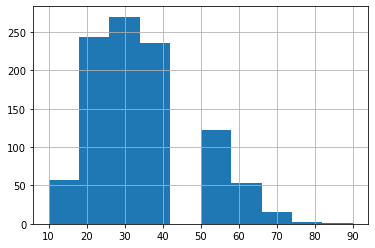

In [26]:
# solution
df2['age'].hist();

## solution
#The reason is that the dataset contains *outliers* - individuals who are very different from the rest of the population. 
#These individuals do not fit easily into any group, even after generalization. 
#Even considering *only* ages, we can see that adding more data is not likely to help, 
#since very low and very high ages are poorly represented in the dataset.
#Achieving the optimal generalization for $k$-Anonymity is very challenging in cases like this. 
#Generalizing each row *more* would be overkill for the well-represented individuals with ages in 
#the 20-40 range, and would hurt utility. However, more generalization is clearly needed for individuals 
#at the upper and lower ends of the age range. This is the kind of challenge that occurs regularly in practice, 
#and is difficult to solve automatically. 
#In fact, optimal generalization for $k$-Anonymity has been shown to be NP-hard.

## 5) Solving the challenge

One solution to this problem is simply to clip the age of each individual in the dataset to lie within a specific range, eliminating outliers entirely. This can also hurt utility, since it replaces real ages with fake ones, but it can be better than generalizing each row more. 

_ToDo:_ $5a)$ Perform the clipping. Ages should be clipped to a certain threshold $t$. Which value of $t$ could be appropriate here? Look at the histograms above. 
Educational levels should stay as they are, e.g. by clipping them to their maximum value in the dataset. Lastly generalize the first 500 rows of the dataset.

In [27]:
#solution
# clipping away outliers
dfp = df.clip(upper=np.array([60, max(df.edu)]), axis='columns')
depths = {
    'age': 1,
    'edu': 1
}
df2 = generalize(dfp.head(500), depths)

_ToDo:_ $5b)$ For which $k$ does the dataset satisfy $k$-Anonymity? Remember to not run function of a large subset of the data, it may take a long time! What is the conclusion?

In [28]:
#solution
isKAnonymized(df2, 7)
#k=7

True

_ToDo:_ $5c)$ What are your conclusions on $k$-Anonymity after this exercise?

In [29]:
#solution
#Now, the generalized dataset satisfies $k$-Anonymity for $k=7$! In other words, our level of generalization was appropriate, 
#but outliers prevented us from achieving $k$-Anonymity before, even for $k=2$.

## Summary

- $k$-Anonymity is a property of data, which ensures that each individual "blends in" with a group of at least $k$ individuals.
- $k$-Anonymity is computationally expensive even to check: the naive algorithm is $O(n^2)$, and faster algorithms take considerable space.
- $k$-Anonymity can be achieved by modifying a dataset by *generalizing* it, so that particular values become more common and groups are easier to form.
- Optimal generalization is extremely difficult, and outliers can make it even more challenging. Solving this problem automatically is NP-hard.


<br/>

**Acknowledgement**

This exercise is extracted and adapted from the open source book: Near, Joseph P. and Abuah, Chiké. (2021) "Programming Differential Privacy". (Vol.1.) https://uvm-plaid.github.io/programming-dp/.
(c) Joseph P. Near and Chiké Abuah